<a href="https://colab.research.google.com/github/DatNguyen2084/DLDH-Metaphor-detection/blob/main/DLDH_BERT_MetaphorDetection_Ternary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DLDH Seminar - Metaphor Detection

Classifying metaphors, metaphor candidates and non-metaphors using BERT.

# Imports

In [ ]:
!pip install -q sentence_transformers
!pip install -q datasets
!pip install --upgrade deepl
!pip install transformers

     |████████████████████████████████| 79 kB 3.6 MB/s 
     |████████████████████████████████| 3.8 MB 12.1 MB/s 
     |████████████████████████████████| 1.2 MB 16.5 MB/s 
     |████████████████████████████████| 67 kB 1.9 MB/s 
     |████████████████████████████████| 895 kB 23.9 MB/s 
     |████████████████████████████████| 6.5 MB 28.8 MB/s 
     |████████████████████████████████| 596 kB 48.2 MB/s 
     |████████████████████████████████| 325 kB 5.3 MB/s 
     |████████████████████████████████| 1.1 MB 42.6 MB/s 
     |████████████████████████████████| 212 kB 47.6 MB/s 
     |████████████████████████████████| 134 kB 49.1 MB/s 
     |████████████████████████████████| 127 kB 45.1 MB/s 
     |████████████████████████████████| 94 kB 2.2 MB/s 
     |████████████████████████████████| 271 kB 51.3 MB/s 
     |████████████████████████████████| 144 kB 49.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source o

In [ ]:
import ast
import copy
import csv
import glob
import json
import random
import transformers
from datetime import datetime

import deepl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from torch import nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from transformers import (AutoConfig, AutoModelForSequenceClassification,
                          AutoTokenizer, BertForSequenceClassification,
                          BertModel, Trainer, TrainingArguments)
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.models.bert.modeling_bert import *
from transformers.utils.dummy_tf_objects import TFDPRQuestionEncoder

# Loading data

In [ ]:
# Mount Google Drive
# The following data is needed: https://drive.google.com/drive/folders/159CN2MDaGLzuoiA7x--Qq5zEdPavFcpf?usp=sharing
# Create a shortcut to your Drive ("Drive-Verknüpfung hinzufügen" zu "Meine Ablage")
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
ROOT_PATH = '/content/drive/MyDrive/DLDH'
DATA_PATH = '/data'
MODEL_PATH = '/model'
RESULTS_PATH = '/results'

### Utils

#### Oversampling

In [ ]:
# If this parameter is set on true, oversampling will be performed on the dataframe
oversample_dataframe = False

# For the use of the Deepl API (is used to oversample the data set), a Deepl Authentication Key is needed
# To obtain such a key, a free trial can be started on the following page: https://www.deepl.com/docs-api/
# When 500.000 characters have been translated, a credit card is needed to start a real abonnement and to access the API
deepl_auth_key = 'DEEPL_AUTH_KEY'

# This parameter specifies the number of iterations after which the intermediate result of the dataframe should be stored repeatedly
backup_oversampled_dataframe_after_rows = 40

def set_default_staerkegrad_df(df):
  """ 
  set_default_staerkegrad accepts a dataframe as input. Checks if there is a column named "Staerkegrad"
  and if there is inserts into empty fields in that column the mostly used value from the column.

  :param df: a pandas dataframe
  :return: a pandas dataframe, where for every undefined entry in the column "Staerkgegrad" the most common value from all rows is set. If there is no such column in the input dataframe, the input dataframe is returned.  
  """
  if ('Stärkegrad (A, B, C)' not in df.columns):
    print('[set_default_staerkegrad_df]: Given dataframe does not consist of a column "Staerkegrad"!')
    return df
  else:
    most_used_staerkegrad = df['Stärkegrad (A, B, C)'].value_counts().index[0]
    df.fillna(value={'Stärkegrad (A, B, C)': most_used_staerkegrad})
    return df

def translate(text, target_language):
  """
  translate translates the input text into the target language.

  :param text: the text to be translated
  :param target_language: the deepl target language expression, examples are 'DE' or 'EN-US'
  :return: a string, the translation of :param text into the :param target_language
  """
  translator = deepl.Translator(deepl_auth_key) 
  result = translator.translate_text(text, target_lang=target_language) 
  translated_text = result.text
  return translated_text

def translate_into_english_and_back(text):
  """
  translate_into_english_and_back translates the input text into english and then into German.

  :param text: the text to be translated
  :return: a string. Returned is the result from translating :param text into englisch and after that into German.
  """
  translator = deepl.Translator(deepl_auth_key) 
  result_eng = translator.translate_text(text, target_lang='EN-US')
  result_ger = translator.translate_text(result_eng.text, target_lang='DE')
  return result_ger.text

def translate_into_target_language_and_back(text, target_language):
  """
  translate_into_target_language_and_back translates the input text into the given target_language and then into German.

  :param text: the text to be translated
  :param target_language: the language
  :return: a string. Returned is the result from translating :param text into :param target_language and then into German. 
  """
  translator = deepl.Translator(deepl_auth_key) 
  result_eng = translator.translate_text(text, target_lang=target_language)
  result_ger = translator.translate_text(result_eng.text, target_lang='DE')
  return result_ger.text

def oversample_dataframe(df):
  """
  Accepts a dataframe and returns the dataframe with oversampled data. The function was written for the known dataset of the Goldstandard. 
  In detail, every Textstelle (from metaphors only) from the input dataframe is taken, translated into four languages (english, spanish, czech and polish) and back into German.
  By this way, for each Textstelle from :param df, four new texts are generated and added to the output dataframe. 

  :param df: a pandas dataframe. 
  :return: a pandas dataframe. In the output dataframe, four columns have been added, in which the different back and forth translated German texts are. 
  """
  # Before the oversampling, the counts of unique rows in the input df and of rows which are metaphors are printed
  print('Ausprägungen und Anzahl Werte für gold_standard_df vor Oversampling:', df['Metapher?'].value_counts())
  print('Metaphern im gold_standard_df vor Oversampling', df['Metapher?'].value_counts().Metapher)

  # To backup interim results, this counter is initialized
  count = 1

  # To keep count of successfully added translated metaphor texts, the following counter is initialized
  count_successfully_added_metaphor_texts = 0

  # Split the input dataframe into two dataframes, one containing only metaphors and one with only not metaphors
  only_metaphor_df = df[(df['Metapher?'] == 'Metapher')]
  no_metaphors_df = df[(df['Metapher?'] != 'Metapher')]

  # To the dataframe containing only metaphors, add four columns where the newly generated texts can be inserted to
  only_metaphor_df['Synonym (aus Englischem)'] = ""
  only_metaphor_df['Synonym (aus Spanischem)'] = ""
  only_metaphor_df['Synonym (aus Tchechischem)'] = ""
  only_metaphor_df['Synonym (aus Polnischem)'] = ""
  
  # Loop over all rows in the dataframe containing only metaphors and translate the text back and forth and insert the German result in the correct dataframe cell
  for index, row in only_metaphor_df.iterrows():
    text = row['Textstelle']
    row['Synonym (aus Englischem)'] = translate_into_target_language_and_back(text, 'EN-US')
    row['Synonym (aus Spanischem)'] = translate_into_target_language_and_back(text, 'ES')
    row['Synonym (aus Tchechischem)'] = translate_into_target_language_and_back(text, 'CS')
    row['Synonym (aus Polnischem)'] = translate_into_target_language_and_back(text, 'PL')
    count_successfully_added_metaphor_texts += 4
    print('working, count:', count)

    # Backup interim results of the dataframe as csv files every 'backup_oversampled_dataframe_after_rows' iterations
    if (count % backup_oversampled_dataframe_after_rows == 0): 
      only_metaphor_df.to_csv('only_metaphor_df_four_languages_backup_iteration_' + str(count) + '.csv', index=False)

    # Increase counter
    count+=1

  # After the for loop, the two dataframes only metaphor and not metaphors need to get concatenated again
  oversampled_data_df = only_metaphor_df.append(no_metaphors_df)

  # After the oversampling, print the counts of unique rows in the oversampled dataframe and of rows which are metaphors again to get an overview on the results of the data augmentation 
  print('Ausprägungen und Anzahl Werte für gold_standard_df nach Oversampling:', oversampled_data_df['Metapher?'].value_counts())
  print('Metaphern im gold_standard_df nach Oversampling', oversampled_data_df['Metapher?'].value_counts().Metapher + count_successfully_added_metaphor_texts)

  return oversampled_data_df


#### Saving Settings

In [ ]:
def save_settings(path, annotators, epochs, folds, model_type, oversampling, smote, comment):
  """
  Saves the given settings to a text file at a given path
  :param path: the path to output the text file to
  :param annotators: The annotators to save 
  :param epochs: The number of epochs to save 
  :param folds: The number of folds to save 
  :param model_type: The model type to save 
  :param oversampling: The boolean if oversampling is activated 
  :param smote: The K for SMOTE to save 
  :param comment: A free comment to save in the text file
  """  
  
  lines = []
  lines.append('Annotators: ' + ', '.join(annotators))
  lines.append('Epochs: ' + str(epochs))
  lines.append('Folds: ' + str(folds))
  lines.append('Model Type: ' + model_type)
  lines.append('Oversampling: ' + ("On" if oversampling else "Off"))
  lines.append('SMOTE: ' + (("On (K="+str(smote)+")") if smote>0 else "Off"))
  lines.append('Comment: ' + comment)

  with open(path+'/settings.txt', 'w') as f: 
    f.write('\n'.join(lines))

  print("Settings saved to", path)

### Load Annotated Data (positive and negative)

In [ ]:
# Loading annotated data for individual annotators
raw_df = pd.read_csv(ROOT_PATH + DATA_PATH + '/Annotationen-Stufe-2.csv', index_col=0)
# Drop rows where Textstelle is NaN
index_names = raw_df[raw_df['Textstelle'].isnull()].index
raw_df.drop(index_names, inplace=True)
# setting the Stärkegrad if not present
raw_df = set_default_staerkegrad_df(raw_df)

,Seite,Textstelle,Metapher?,Fokus,Rahmen,"Stärkegrad (A, B, C)",Begründung/Kommentar,Annotator,Unnamed: 2,Semantikerweiterung?,Unersetzlich?,sprachlich irregulär?,pointiert?
0,NaN,Bei Beobachtung solchen moralischen Wertes ka...,Metapher,das Horoskop stellen,einer Nation,B,Horoskop stellen - bezogen auf Nationen ist da...,B,NaN,NaN,NaN,NaN,NaN
1,NaN,Die Zellen verschmelzen miteinander.,Metaphernkandidat,NaN,NaN,NaN,Fachausdruck,B,NaN,NaN,NaN,NaN,NaN
2,NaN,"Diese wolle die bittere Auslese, ohne die auc...",Metapher,bittere,Auslese,A,"Unauffällig, aber doch metaphorisch: Dass eine...",B,NaN,NaN,NaN,NaN,NaN
3,NaN,"Wenn es dem Verfasser gelungen ist, ein gesic...",Metapher,ein gesichertes Fundament und die ersten Pfeil...,die Lösung der hier zur Bearbeitung gestellten...,A,"Bruch, Fokus nicht ohne Bedeutungsverlust erse...",B,NaN,NaN,NaN,NaN,NaN
4,NaN,In Californien ist ebenso die früher dort hei...,Metaphernkandidat,NaN,NaN,NaN,"kein Bruch, nur auffälliger Ausdruck, keine Be...",B,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2579,NaN,In ähnlicher Weise sollen noch mehrere andere ...,Metaphernkandidat,NaN,NaN,NaN,NaN,B,NaN,NaN,NaN,NaN,NaN
2580,NaN,"Die Amerikaner folgern, da sie alle Rohmateria...",Metapher,einer turmhohen Mauer,Schutzzöllen,A,NaN,B,NaN,NaN,NaN,NaN,NaN
2581,NaN,Sie könne bei ihrer jetzigen großen Kraft und ...,Metapher,mütterlichen Päppelflasche,Sie,B,NaN,B,NaN,NaN,NaN,NaN,NaN
2582,NaN,"Schwarze Flecken von Habgier, Raubsucht, Unger...",Metaphernkandidat,NaN,NaN,NaN,NaN,B,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Loading annotated data of the gold standard
gold_standard_df = pd.read_csv(ROOT_PATH + DATA_PATH + '/goldstandard_dataframe_oversampled.csv')

# Loading annotated data for non-metaphors
no_metaphor_df = pd.read_csv(ROOT_PATH + DATA_PATH + '/NoMetaphor.csv', index_col=0)

# Combine all data into one DataFrame
raw_df = pd.concat([raw_df, gold_standard_df, no_metaphor_df], axis=0,ignore_index=True)

# If the related parameter is set to true and a valid Deepl API Key is present, oversampling will be performed on the raw_df and this oversampled_data_df will be saved as .csv file
if (oversample_dataframe and deepl_auth_key != 'DEEPL_AUTH_KEY'):
  oversampled_data_df = oversample_dataframe(gold_standard_df)
  oversampled_data_df.to_csv('goldstandard_dataframe_oversampled.csv', index=False)

display(raw_df[raw_df['Metapher?'] == 'Metapher'])

,Seite,Textstelle,Metapher?,Fokus,Rahmen,"Stärkegrad (A, B, C)",Begründung/Kommentar,Annotator,Unnamed: 2,Semantikerweiterung?,Unersetzlich?,sprachlich irregulär?,pointiert?,Filename,Synonym (aus Englischem),Synonym (aus Spanischem),Synonym (aus Tchechischem),Synonym (aus Polnischem)
0,NaN,Bei Beobachtung solchen moralischen Wertes ka...,Metapher,das Horoskop stellen,einer Nation,B,Horoskop stellen - bezogen auf Nationen ist da...,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,"Diese wolle die bittere Auslese, ohne die auc...",Metapher,bittere,Auslese,A,"Unauffällig, aber doch metaphorisch: Dass eine...",B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,"Wenn es dem Verfasser gelungen ist, ein gesic...",Metapher,ein gesichertes Fundament und die ersten Pfeil...,die Lösung der hier zur Bearbeitung gestellten...,A,"Bruch, Fokus nicht ohne Bedeutungsverlust erse...",B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,Man kann vielmehr in das Getriebe des gesells...,Metapher,Leuchte der Wissenschaft,in das Getriebe des gesellschaftlichen Lebens,B,"Bruch, semantische Erweiterung, nicht ersetzba...",B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,"Wohlfahrt hätte, wäre ein absurdum. Dies komm...",Metapher,fast die ganze Außenwelt lückenlos umspannen,des Menschen Interessen,B,"Irritation, unersetzlich, Bedeutungserweiterun...",B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2690,NaN,137\tAm einfachsten und am schnellsten wird de...,Metapher,"['der gordische Knoten', 'dem Schwerte', 'durc...","['dieser Frage', 'des ""frommen Glaubens""', '',...",NaN,NaN,GoldStandard,NaN,NaN,NaN,NaN,NaN,"['Haeckel_Lebenswunder_Stufe2_B.xmi', 'Haeckel...","137 Der einfachste und schnellste Weg, den gor...","137 Der einfachste und schnellste Weg, den gor...","137 Der einfachste und schnellste Weg, den gor...","Der einfachste und schnellste Weg, den gordisc..."
2691,NaN,"188\tIndem ich meine Leser einlade, mit mir da...",Metapher,"['der engen Eingangspforte', 'Eintrittskarte',...",['das weite Gebiet der monistischen Philosophi...,NaN,NaN,GoldStandard,NaN,NaN,NaN,NaN,NaN,"['Haeckel_Lebenswunder_Stufe2_B.xmi', 'Haeckel...","188 Indem ich meine Leser einlade, mit mir noc...","188 Indem ich meine Leser einlade, mit mir noc...","188 Wenn ich meine Leser einlade, mit mir das ...","188 Indem ich meine Leser einlade, mit mir noc..."
2692,NaN,"Hat aber die Abstammungslehre recht, so muß si...",Metapher,"['keine Violine', 'keine Violine da ist']","['lückenlosen Übergänge', 'um sie zum Ausdruck...",NaN,NaN,GoldStandard,NaN,NaN,NaN,NaN,NaN,"['Haecker_Stufe2_T.xmi', 'Haecker_Stufe2_P.xmi...","Wenn aber die Abstammungstheorie richtig ist, ...","Aber wenn die Abstammungstheorie richtig ist, ...","Aber wenn die Ursprungstheorie richtig ist, mu...","Aber wenn die Abstammungstheorie richtig ist, ..."
2693,NaN,Lassen sich nach dem zuletztGesagten die Organ...,Metapher,"['Damm', 'durchbricht', 'Damm']",['naturwissenschaftlicher Forschnngsgrundsätze...,NaN,NaN,GoldStandard,NaN,NaN,NaN,NaN,NaN,"['Haecker_Stufe2_T.xmi', 'Haecker_Stufe2_T.xmi...",Wenn nach Letzterem Organismen nicht nur mit R...,Wenn demnach Organismen nicht nur mit den Prod...,Wenn nach ihm Organismen nicht nur mit Produkt...,Wenn nach dieser Auffassung Organismen nicht n...


### Get data by annotator

In [ ]:
# annotators = ['T', 'A', 'P', 'B', 'K']
def get_class_data_by_annotator(annotator = 'all', class_name = 'Metapher', size= 0)-> pd.DataFrame:
  """
  Gets the class data by annotator
  :param annotator: the specific annotator to data from. If 'all', data from all annotators is returned
  :param class_name: The name of the class which should be returned
  :param size: The size of the returned dataframe. If size=0, all data is returned
  :return df: A dataframe of given size, containing all data of a given annotator and class
  """  
  annotators = set(raw_df['Annotator'].tolist())
  if annotator == 'all':
    df = raw_df.loc[(raw_df['Annotator'].isin(['T', 'A', 'P', 'B', 'K', 'GoldStandard', 'X']) ) & (raw_df['Metapher?'] == class_name)]
  elif annotator not in annotators:
    raise Exception('The given Annotator is not found')
  else:
    df = raw_df.loc[(raw_df['Annotator'] == annotator) & (raw_df['Metapher?'] == class_name)]

  # shuffle rows
  df = df.sample(frac=1).reset_index(drop=True)

  if size != 0:
    df = df.head(size)

  return df

,Seite,Textstelle,Metapher?,Fokus,Rahmen,"Stärkegrad (A, B, C)",Begründung/Kommentar,Annotator,Unnamed: 2,Semantikerweiterung?,Unersetzlich?,sprachlich irregulär?,pointiert?,Filename,Synonym (aus Englischem),Synonym (aus Spanischem),Synonym (aus Tchechischem),Synonym (aus Polnischem)
0,NaN,"Es scheint mir allerhöchste Zeit, an eine syst...",Nein,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,nus5_2_Michaelis_bereinigt.txt,NaN,NaN,NaN,NaN
1,NaN,"Es ist auch nicht möglich, dieser Subjektivitä...",Nein,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,nus2_2_ruppin_bereinigt.txt,NaN,NaN,NaN,NaN


# Baseline

A simple Baseline using the DummyClassifier of sklearn. For more details see: https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

In [ ]:
def baseline(train_texts, test_texts, train_labels, test_labels, strategy="most_frequent"):
  """
  Returns the Accuracy, Average Macro F1 score and individual Macro F1 score for each class for a given set of train and test data with a given 
  :param train_texts: The train set
  :param test_texts: The test set
  :param train_labels: The train labels
  :param test_labels: The test labels
  :param strategy: The strategy for the classifier (for example 'most_frequent', 'stratified')
  :return acc: The accuracy of the baseline classifier on the given data with the given strategy
  :return macro_f1: The average Macro F1 score of the baseline classifier on the given data with the given strategy
  :return per_class_macro_f1: The individual class Macro F1 scores of the baseline classifier on the given data with the given strategy
  """  
  dummy_clf = DummyClassifier(strategy=strategy)
  dummy_clf.fit(train_texts, train_labels)
  prediction = dummy_clf.predict(test_texts)
  # calculate accuracy using sklearn's function
  test_labels = test_labels.to_numpy(dtype=int)
  prediction = prediction.astype(int)
  acc = accuracy_score(test_labels, prediction)
  macro_f1 = f1_score(test_labels, prediction, average='macro')
  per_class_macro_f1 = f1_score(test_labels, prediction, average=None).tolist()

  display("-----------------------------------")
  display("Baseline using strategy=", strategy)
  display("Accuracy:", acc)
  display("Macro F1:", macro_f1)
  display("Per Class Macro F1:", per_class_macro_f1)
  display("-----------------------------------")

  return acc, macro_f1, per_class_macro_f1

# BERT

## Load pre-trained BERT

In [ ]:
def load_model_tokenizer(model_type='fine_tuned', smote=False):
  """
  Returns an individual model and corresponding tokenizer 
  :param model_type: The type of model to load
  :param smote: The test set
  :return model: The average Macro F1 score of the baseline classifier on the given data with the given strategy
  :return tokenizer: The individual class Macro F1 scores of the baseline classifier on the given data with the given strategy
  """    

  if model_type == 'fine_tuned':
    if smote>0:
      model = BertForSequenceClassificationSMOTE.from_pretrained(ROOT_PATH + MODEL_PATH, cache_dir=None, num_labels=3)
    else:
      model = BertForSequenceClassification.from_pretrained(ROOT_PATH + MODEL_PATH, cache_dir=None, num_labels=3)
    tokenizer = AutoTokenizer.from_pretrained(ROOT_PATH + MODEL_PATH)
  elif model_type == 'intermediate_task_vua':
    if smote>0:
      model = BertForSequenceClassificationSMOTE.from_pretrained(ROOT_PATH + '/intermediate-task-vua/model', num_labels=3, ignore_mismatched_sizes=True)
    else:
      model = BertForSequenceClassification.from_pretrained(ROOT_PATH + '/intermediate-task-vua/model', num_labels=3, ignore_mismatched_sizes=True)
    tokenizer = AutoTokenizer.from_pretrained(ROOT_PATH + '/intermediate-task-trofi-vua/model')
  elif model_type == 'intermediate_task_trofi':
    if smote>0:
      model = BertForSequenceClassificationSMOTE.from_pretrained(ROOT_PATH + '/intermediate-task-trofi/model', num_labels=3, ignore_mismatched_sizes=True)
    else:
      model = BertForSequenceClassification.from_pretrained(ROOT_PATH + '/intermediate-task-trofi/model', num_labels=3, ignore_mismatched_sizes=True)
    tokenizer = AutoTokenizer.from_pretrained(ROOT_PATH + '/intermediate-task-trofi/model')
  elif model_type == 'bert_base_multilingual_cased':
    if smote:
      model = BertForSequenceClassificationSMOTE.from_pretrained("bert-base-multilingual-cased", cache_dir=None, num_labels=3)
    else:
      model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", cache_dir=None, num_labels=3)
    tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
  elif model_type == 'redewiedergabe':
    if smote:
      model = BertForSequenceClassificationSMOTE.from_pretrained("redewiedergabe/bert-base-historical-german-rw-cased", cache_dir=None, num_labels=3)
    else:
      model = BertForSequenceClassification.from_pretrained("redewiedergabe/bert-base-historical-german-rw-cased", cache_dir=None, num_labels=3)
    tokenizer = AutoTokenizer.from_pretrained("redewiedergabe/bert-base-historical-german-rw-cased")
  return model, tokenizer


## Dataset Definition

In [ ]:
class MetaphorDataset(torch.utils.data.Dataset):
  """
  The dataset class for metaphors
  """
    def __init__(self, encodings, labels):
    """
    Initializes the dataset
    :param encodings: The type of model to load
    :param labels: Boolean value to toggle SMOTE
    """    
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
    """
    Returns an individual item by id
    :param idx: The id of the item to return
    :return item: The chosen item
    """    
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
    """
    Helper to return the size of the dataset
    :return lenght: the size of the dataset
    """    
        return len(self.labels)

def compute_metrics(pred):
    """
    Computes accuracy, macro_f1 score and individual macro f1 per class for a given prediction
    :param pred: The prediction
    :return dict: A dictionary containing accuracy, macro_f1 score and individual macro f1 per class
    """    
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # calculate accuracy using sklearn's function
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average='macro')
    per_class_macro_f1 = f1_score(labels, preds, average=None).tolist()
    return {
        'accuracy': acc,
        'macro_f1': macro_f1,
        'per_class_macro_f1': per_class_macro_f1,
    }

## BERT Utilities

In [ ]:
def save_results(path, results, annotator):
  """
  Saves the results of a training to a given path
  :param path: The path to save to
  :param results: The results to save
  :param annotator: The annotator of this particular result
  """    
  print("Saving results to", path)
  with open(path + '/results_'+annotator+'.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in results.items():
       writer.writerow([key, value])

In [ ]:
def get_numerical_labels(df):  
  """
  Returns the labels as numerical values: '0' for Non-Metaphors, '1' for Metaphor candidates and '2' for Metaphors
  :param df: The dataframe to change
  :return df: The changed dataframe, containing labels as numerical values
  """ 
  df.loc[df['Metapher?'] == 'Nein', 'Metapher?'] = 0
  df.loc[df['Metapher?'] == 'Metaphernkandidat', 'Metapher?'] = 1
  df.loc[df['Metapher?'] == 'Unklar', 'Metapher?'] = 1
  df.loc[df['Metapher?'] == 'Grenzfall', 'Metapher?'] = 1
  df.loc[df['Metapher?'] == 'Metapher', 'Metapher?'] = 2
  return df

In [ ]:
 def get_oversamples(entry):
  """
  Returns the oversampling entries corresponding to a specific entry
  :param entry: The entry to get the oversampling data to
  :return oversamples: The oversampling data to the given entry
  """ 
  oversamples = pd.DataFrame()
  textstelle = entry['Textstelle']
  # getting oversampling data from gold standard
  gold_standard_entry = get_numerical_labels(gold_standard_df[gold_standard_df['Textstelle']==textstelle])
  for language in ["Synonym (aus Englischem)", "Synonym (aus Spanischem)", "Synonym (aus Tchechischem)", "Synonym (aus Polnischem)"]:
    oversamples= oversamples.append(gold_standard_entry)
    oversamples.iloc[-1]['Textstelle'] = oversamples.iloc[-1][language]
  return oversamples

def generate_oversampled_data(df, size):
  """
  Generates oversampled data to given data with a specific size by randomly selecting from all oversampling data
  :param df: The data for which oversampling data should be generated
  :param size: The size of the generated data
  :return new_samples: The oversampling data to the given data with given size
  """   
  new_samples = pd.DataFrame()
  for index, row in df.iterrows():
    new_samples= new_samples.append(get_oversamples(row))
  return new_samples.sample(size)

In [ ]:
 def df_statistics(df):
    """
    Generates a statistic of a given dataframe
    :param df: The data for which a statistic should be generated
    :return statistic: The statistic of the given dataframe
    """   
    return "non-metaphors: {} ({:.0%}), metaphor candidates: {} ({:.0%}), metaphors: {} ({:.0%})".format(df['Metapher?'].value_counts()[0],df['Metapher?'].value_counts()[0]/df['Metapher?'].value_counts().sum(),df['Metapher?'].value_counts()[1],df['Metapher?'].value_counts()[1]/df['Metapher?'].value_counts().sum(),df['Metapher?'].value_counts()[2],df['Metapher?'].value_counts()[2]/df['Metapher?'].value_counts().sum())

## BertForSequenceClassification with Synthetic Minority Oversampling Technique (SMOTE)

In [ ]:
class BertForSequenceClassificationSMOTE(BertPreTrainedModel):
    """
    The BERT model class using SMOTE 
    """
    def __init__(self, config):
        """
        Initializes the Model
        :param config: The configuration for the BERT model
        """   
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        self.bert = BertModel(config)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        # the individual points which are used for SMOTE and collected in the first epoch
        self.points = []
        # counts the amount of SMOTE samples created
        self.smote_counter = 0
        # The number of original samples in the minority class
        self.minority_class = 0
        # The factor of how many SMOTE samples should be produced per original sample
        self.smote_factor = 0
        # define k for k nearest neigbors
        self.smote_k = 10
        self.initialization = True
        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)


        if self.initialization:
          for label, output in zip(labels, pooled_output):
            if label == 2:
              self.points.append(output.detach())

        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"
            
            if self.training and not self.initialization:
              SMOTE_output = pooled_output
              SMOTE_labels = labels
              for label, output in zip(labels, pooled_output):
                if self.initialization and label == 2:
                  self.points.append(output.detach())
                
                # if training sample is in class 2 (i.e. metaphor)
                elif label == 2:
                  # get distances to all other points
                  distances = list()
                  for point in self.points:
                      current_distance = torch.dist(output, point)
                      if current_distance != 0:
                        distances.append((point,current_distance))
                  distances.sort(key=lambda tuple: tuple[1])

                  for i in range(self.smote_factor):
                    # chose a neighboring point
                    chosen_neighbor = distances[random.randint(0,self.smote_k)][0]

                    rand = torch.Tensor(output.shape)
                    rand = rand.cuda()
                    rand.random_(0, 1)
                    # create a random synthetic datapoint between the current point and the chosen neighbor
                    synthetic_datapoint = torch.add(output,
                                                    torch.mul(rand, torch.add(chosen_neighbor, torch.neg(output))))
                    
                    # add synthetic point to train_set
                    SMOTE_output = torch.cat((SMOTE_output, synthetic_datapoint.view(1, -1)), 0)
                    
                    SMOTE_labels = torch.cat((SMOTE_labels, torch.tensor([[2]], dtype=torch.long).cuda()))

                    self.smote_counter += 1

              pooled_output = self.dropout(SMOTE_output)
              labels = SMOTE_labels
            else:
              pooled_output = self.dropout(pooled_output)

            logits = self.classifier(pooled_output)

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        if self.initialization and len(self.points) >= self.minority_class:
          # after initializing the SMOTE embedding space, stop initialization
          self.initialization = False
          print("SMOTE embedding space initialized.")

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
def get_smote_points(model, minority_class, train_dataset, test_dataset):
  """
  Initializes the embedding space for the k-nearest neighbor algorithm use by SMOTE
  Due to Google Colab limitations, this is implemented via an evaluation
  :param model: The model to initialize
  :param minority_class: The minority to oversample via SMOTE
  :param train_dataset: The train dataset
  :param test_dataset: The test dataset
  :return model.points: The initialized data points
  """   
  print("**** Saving all points in train set for SMOTE initialization *****")
  model.minority_class=minority_class

  training_args = TrainingArguments(
      output_dir='./results',          # output directory
      num_train_epochs=1,              # total number of training epochs
      per_device_train_batch_size=8,  # batch size per device during training
      per_device_eval_batch_size=20,   # batch size for evaluation
      warmup_steps=500,                # number of warmup steps for learning rate scheduler
      weight_decay=0.01,               # strength of weight decay
      logging_dir='./logs',            # directory for storing logs
      load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
      # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
      save_total_limit=1,
      save_strategy="epoch",
      logging_strategy="epoch",
      evaluation_strategy="epoch",     # evaluate each `logging_steps`
      metric_for_best_model="macro_f1",
  )

  trainer = Trainer(
      model=model,                         # the instantiated Transformers model to be trained
      args=training_args,                  # training arguments, defined above
      train_dataset=train_dataset,         # training dataset
      eval_dataset=test_dataset,          # evaluation dataset
      compute_metrics=compute_metrics,     # the callback that computes metrics of interest
  )

  trainer.evaluate(train_dataset)
  model.initialization = False

  return model.points

##Training Definition

In [ ]:
# setting the maximum sentence length
max_length = 512
# setting the default stärkegrad of the raw data
raw_df = set_default_staerkegrad_df(raw_df)

def train(annotator, model_type, epochs=3, folds=10, oversampling=True, smote=0, path='/'):
  """
  Training a given model with k-fold cross-validation and various oversampling strategies
  The resulting metrics are saved as CSV to a given path
  :param annotator: The annotator on whose data to train
  :param model_type: The type of model to use
  :param epochs: The amount of epochs to train
  :param folds: The amount of folds to use for k-fold cross validation
  :param oversampling: Boolean to set true if oversampling should be used
  :param smote: K value for smote. If set to 0, smote is deactivated
  :param path: The path to save the results to
  :return evaluation_results: The results of the evaluation of the trained model
  """     
  print("Training with data from annotator", annotator)
  metaphor_candidates = get_class_data_by_annotator(annotator, class_name='Metaphernkandidat')
  metaphors = get_class_data_by_annotator(annotator, class_name='Metapher')
  # Using only the same amount of non-metaphors as metaphor candidates
  not_metaphors = get_class_data_by_annotator(class_name='Nein', size=len(metaphor_candidates))

  df = pd.concat([metaphors, metaphor_candidates, not_metaphors])
  # Shuffle the rows  
  df = df.sample(frac=1).reset_index(drop=True)

  # Data Statistics
  samples = len(metaphor_candidates)+len(metaphors)+len(not_metaphors)
  print("Number of individual classes in data:", df_statistics(df))

  # changing the labels to numerical values
  df = get_numerical_labels(df)

  baseline_accuracy = []
  baseline_macro_f1 = []
  baseline_per_class_macro_f1 = []

  evaluation_accuracy = []
  evaluation_macro_f1 = []
  evaluation_per_class_macro_f1 = []


  # K-Fold Cross Validation
  kf = StratifiedKFold(n_splits=folds, shuffle=False)
  i = 0
  for train_index, test_index in kf.split(df['Textstelle'], df['Metapher?'].to_list()):
    
    model, tokenizer = load_model_tokenizer(model_type=model_type, smote=smote)
    i += 1
    display("-----------------------------------")
    print("Annotator", annotator, "| Fold #", i)

    train_samples = df.iloc[train_index.tolist()]
    test_samples = df.iloc[test_index.tolist()]

    train_metaphors = train_samples[train_samples["Metapher?"] == 2]
    test_metaphors = test_samples[test_samples["Metapher?"] == 2]

    #print("Number of individual classes in train:", df_statistics(train_samples))
    #print("Number of individual classes in test:", df_statistics(test_samples))

    if oversampling:
      # add oversampled metaphors
      oversampled__train_samples = generate_oversampled_data(df=train_metaphors, size=(train_samples['Metapher?'].value_counts()[0]-train_samples['Metapher?'].value_counts()[2]))

      train_samples = pd.concat([train_samples, oversampled__train_samples]) 

    #print("Number of individual classes in train (after oversampling):", df_statistics(train_samples))
    #print("Number of individual classes in test (after oversampling):", df_statistics(test_samples))


    train_texts = train_samples['Textstelle']
    test_texts = test_samples['Textstelle']
    train_labels = train_samples['Metapher?']
    test_labels = test_samples['Metapher?']

    # Baseline
    b_acc, b_macro_f1, b_per_class_macro_f1 = baseline(train_texts, test_texts, train_labels, test_labels, strategy="stratified") # use 'most_frequent' 'stratified' or 'uniform'

    baseline_accuracy.append(b_acc)
    baseline_macro_f1.append(b_macro_f1)
    baseline_per_class_macro_f1.append(b_per_class_macro_f1)
    
    train_encodings = tokenizer(train_texts.to_list(), truncation=True, padding=True, max_length=max_length)
    test_encodings = tokenizer(test_texts.to_list(), truncation=True, padding=True, max_length=max_length)


    # convert our tokenized data into a torch Dataset
    train_dataset = MetaphorDataset(train_encodings, train_labels.tolist())
    test_dataset = MetaphorDataset(test_encodings, test_labels.tolist())

    if smote>0:
      get_smote_points(model, train_samples['Metapher?'].value_counts()[2], train_dataset, test_dataset)
      model.smote_factor = int(train_samples['Metapher?'].value_counts()[0]/train_samples['Metapher?'].value_counts()[2])-1
      model.smote_k = smote

    training_args = TrainingArguments(
        output_dir='./results',          # output directory
        num_train_epochs=epochs,              # total number of training epochs
        per_device_train_batch_size=8,  # batch size per device during training
        per_device_eval_batch_size=20,   # batch size for evaluation
        warmup_steps=500,                # number of warmup steps for learning rate scheduler
        weight_decay=0.01,               # strength of weight decay
        logging_dir='./logs',            # directory for storing logs
        load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
        # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
        save_total_limit=1,
        save_strategy="epoch",
        logging_strategy="epoch",
        evaluation_strategy="epoch",     # evaluate each `logging_steps`
        metric_for_best_model="macro_f1",
    )

    trainer = Trainer(
        model=model,                         # the instantiated Transformers model to be trained
        args=training_args,                  # training arguments, defined above
        train_dataset=train_dataset,         # training dataset
        eval_dataset=test_dataset,          # evaluation dataset
        compute_metrics=compute_metrics,     # the callback that computes metrics of interest
    )

    trainer.train()
    #print("SMOTE created", model.smote_counter, "synthetic data points")

    evaluation = trainer.evaluate()

    evaluation_accuracy.append(evaluation['eval_accuracy'])
    evaluation_macro_f1.append(evaluation['eval_macro_f1'])
    evaluation_per_class_macro_f1.append(evaluation['eval_per_class_macro_f1'])
  
  evaluation_results = {
    "baseline_accuracy": baseline_accuracy,
    "baseline_macro_f1": baseline_macro_f1,
    "baseline_per_class_macro_f1": baseline_per_class_macro_f1,
    "evaluation_accuracy": evaluation_accuracy,
    "evaluation_macro_f1": evaluation_macro_f1,
    "evaluation_per_class_macro_f1": evaluation_per_class_macro_f1
  }

  try:
    save_results(path,evaluation_results, annotator)
  except:
    print("There seems to be a problem with Google Drive. The CSV could not be saved. Results are only stored locally in results[annotator].")
  return evaluation_results

# Training

In [ ]:
#########################
# Parameters for Training
ANNOTATORS = ['T', 'A', 'P', 'B', 'K', 'GoldStandard'] # specify the annotators on which to train. Possible annotators = ['T', 'A', 'P', 'B', 'K', 'GoldStandard']
EPOCHS=3
FOLDS=10
OVERSAMPLING = False
SMOTE = 0 #This defines the factor k for k-nearest-neighbors used by SMOTE. SMOTE is off if set to 0.
COMMENT='Unbalanced for all annotators.'
#########################
transformers.logging.set_verbosity_error()

current_results = {}
SAVE_RESULTS = True
foldernames = [] 

models = ['redewiedergabe', 'fine_tuned', 'bert_base_multilingual_cased', 'intermediate_task_trofi', 'intermediate_task_vua'] # possible model_types are 'redewiedergabe', 'bert_base_multilingual_cased', 'fine_tuned', 'intermediate_task_trofi' and 'intermediate_task_vua'
for model in models: 
  folder_name = datetime.today().strftime('%Y-%m-%d-%H:%M:%S') + " | " + model + " | EPOCHS "+ str(EPOCHS)+ " | FOLDS "+ str(FOLDS)+ ((" | SMOTE (K="+str(SMOTE)+")") if SMOTE>0 else "") + ((" | OVERSAMPLING") if OVERSAMPLING>0 else "")
  RUN_PATH = ROOT_PATH + RESULTS_PATH + '/runs/' + folder_name

  if SAVE_RESULTS:
    print(RUN_PATH)
    !mkdir "$RUN_PATH"
    save_settings(RUN_PATH, ANNOTATORS, EPOCHS, FOLDS, model, OVERSAMPLING, SMOTE, COMMENT)
    foldernames.append(folder_name)

  for annotator in ANNOTATORS: 
    result = train(annotator, model, epochs=EPOCHS, folds=FOLDS, oversampling=OVERSAMPLING, smote=SMOTE, path=RUN_PATH) 
    current_results[annotator] = result
    foldernames.append(folder_name)

NameError: ignored

# Plotting

In [ ]:
def open_csv(path):
  """
  Loads all CSV data for plotting
  :param path: The path to load from
  :return df: The loaded data as a dataframe
  """
  df = pd.read_csv(path, names=['measure', 'results'], header=None)
  annotator = path[-5]
  
  df['results'] = df['results'].apply(lambda x: np.array(json.loads(x)))
  df['annotator'] = annotator
  return df

# Plotting with multiple annotators
def open_csv_annotators(path, annotator):
  """
  Loads all CSV data for plotting for individual annotators
  :param path: The path to load from
  :return df: The loaded data as a dataframe
  """
  print(path)
  try:
    df = pd.read_csv(path, names=['measure', 'results'], header=None)
    df['results'] = df['results'].apply(lambda x: np.fromstring(x[1:-1], sep=', '))
    df['annotator'] = annotator
    annotator_names.append(annotator)
  except:
    df = pd.DataFrame()
  return df

## Gold Standard

All results of our runs can be found in the following folders

In [ ]:
# Unbalanced data 
unbalanced = ["2022-03-18-14:22:25 | redewiedergabe | EPOCHS 3 | FOLDS 10", 
         "2022-03-18-15:39:18 | fine_tuned | EPOCHS 3 | FOLDS 10", 
        "2022-03-18-19:58:33 | bert_base_multilingual_cased | EPOCHS 3 | FOLDS 10",
         "2022-03-18-16:56:29 | intermediate_task_trofi | EPOCHS 3 | FOLDS 10",
         "2022-03-18-22:39:23 | intermediate_task_vua | EPOCHS 3 | FOLDS 10"]

# Oversampling data
oversampling = ["2022-03-18-15:45:00 | redewiedergabe | EPOCHS 3 | FOLDS 10 | OVERSAMPLING", 
         "2022-03-18-17:23:14 | fine_tuned | EPOCHS 3 | FOLDS 10 | OVERSAMPLING", 
         "2022-03-19-16:33:56 | bert_base_multilingual_cased | EPOCHS 3 | FOLDS 10 | OVERSAMPLING",
         "2022-03-18-19:04:18 | intermediate_task_trofi | EPOCHS 3 | FOLDS 10 | OVERSAMPLING",
         "2022-03-18-21:23:18 | intermediate_task_vua | EPOCHS 3 | FOLDS 10 | OVERSAMPLING"]

# SMOTE data 
smote = ["2022-03-18-15:27:18 | redewiedergabe | EPOCHS 3 | FOLDS 10 | SMOTE (K=10)", 
         "2022-03-18-16:54:45 | fine_tuned | EPOCHS 3 | FOLDS 10 | SMOTE (K=10)", 
         "2022-03-19-14:49:00 | bert_base_multilingual_cased | EPOCHS 3 | FOLDS 10 | SMOTE (K=10)",
         "2022-03-19-09:03:31 | intermediate_task_trofi | EPOCHS 3 | FOLDS 10 | SMOTE (K=10)", 
         "2022-03-19-10:53:52 | intermediate_task_vua | EPOCHS 3 | FOLDS 10 | SMOTE (K=10)"]

/content/drive/My Drive/DLDH/results/plots/results-oversampling.pdf


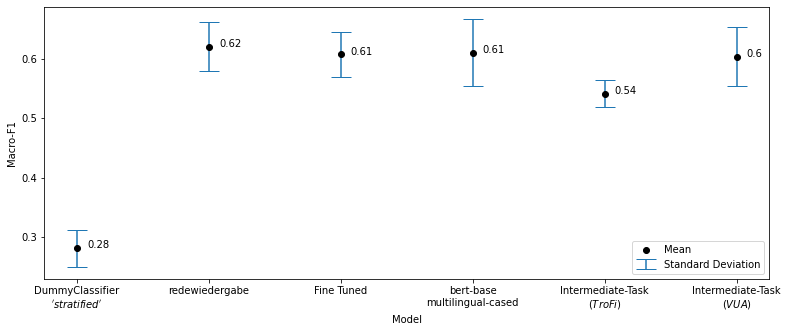

In [ ]:
# Filename to save the plot to
filename = "results-oversampling"

files = oversampling # insert foldernames of previous runs here if needed for plotting

files = [ROOT_PATH + RESULTS_PATH + "/runs/" +  x + "/results_GoldStandard.csv" for x in files]
dfs = [open_csv(filename) for filename in files]

redewiedergabe = open_csv(files[0])
fine_tuned = open_csv(files[1])
bert_base_multilingual = open_csv(files[2])
intermediate_task = open_csv(files[3])
intermediate_task_vua = open_csv(files[4])

models = {'DummyClassifier\n$\it{\'stratified\'}$': (redewiedergabe[(redewiedergabe.measure == 'baseline_accuracy')].results.iloc[0], redewiedergabe[(redewiedergabe.measure == 'baseline_macro_f1')].results.iloc[0]), 
          'redewiedergabe': (redewiedergabe[(redewiedergabe.measure == 'evaluation_accuracy')].results.iloc[0], redewiedergabe[(redewiedergabe.measure == 'evaluation_macro_f1')].results.iloc[0]),
          'Pretrained':(fine_tuned[(fine_tuned.measure == 'evaluation_accuracy')].results.iloc[0], fine_tuned[(fine_tuned.measure == 'evaluation_macro_f1')].results.iloc[0]),
          'bert-base\nmultilingual-cased':(bert_base_multilingual[(bert_base_multilingual.measure == 'evaluation_accuracy')].results.iloc[0], bert_base_multilingual[(bert_base_multilingual.measure == 'evaluation_macro_f1')].results.iloc[0]),
          'Intermediate-Task\n($\it{TroFi}$)': (intermediate_task[(intermediate_task.measure == 'evaluation_accuracy')].results.iloc[0], intermediate_task[(intermediate_task.measure == 'evaluation_macro_f1')].results.iloc[0]),
          'Intermediate-Task\n($\it{VUA}$)': (intermediate_task_vua[(intermediate_task_vua.measure == 'evaluation_accuracy')].results.iloc[0], intermediate_task_vua[(intermediate_task_vua.measure == 'evaluation_macro_f1')].results.iloc[0])
          } 


plt.figure(figsize=(13,5))
plt.xlabel("Model")
plt.ylabel("Macro-F1")
mean = []
std = []
mean_macro = []
std_macro = []
model_names = []


for name, data in models.items():
  accuracy = data[0]
  mean.append(np.mean(accuracy))
  std.append(np.std(accuracy))
  macro_f1 = data[1]
  mean_macro.append(np.mean(macro_f1))
  std_macro.append(np.std(macro_f1))
  model_names.append(name)


plt.errorbar(model_names, mean_macro, yerr=std_macro, capsize=10, ls='none', label='Standard Deviation')
plt.scatter(model_names, mean_macro, c='black', zorder=2, label='Mean')
for i, v in enumerate(mean_macro):
  plt.annotate(round(v, 2), (i, v),xytext=(10, 0), textcoords='offset points')
filepath = ROOT_PATH + RESULTS_PATH + '/plots/' + filename + '.pdf'
print(filepath)
plt.title("")
plt.legend(loc='lower right')
plt.savefig(filepath, bbox_inches='tight')
plt.show()

### Individual classes

Oversampled & 0.34 (0.05) & 0.57 (0.02) & 0.56 (0.05) & 0.53 (0.03) & 0.48 (0.04) & 0.51 (0.02) \\ dataset & \small [0.4, 0.5, 0.1] & \small [0.9, 0.8, 0.0] & \small [0.9, 0.8, 0.1] & \small [0.8, 0.8, 0.0] & \small [0.7, 0.7, 0.0] & \small [0.8, 0.7, 0.0]
/content/drive/MyDrive/DLDH/results/plots/results-unbalanced-individual.pdf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


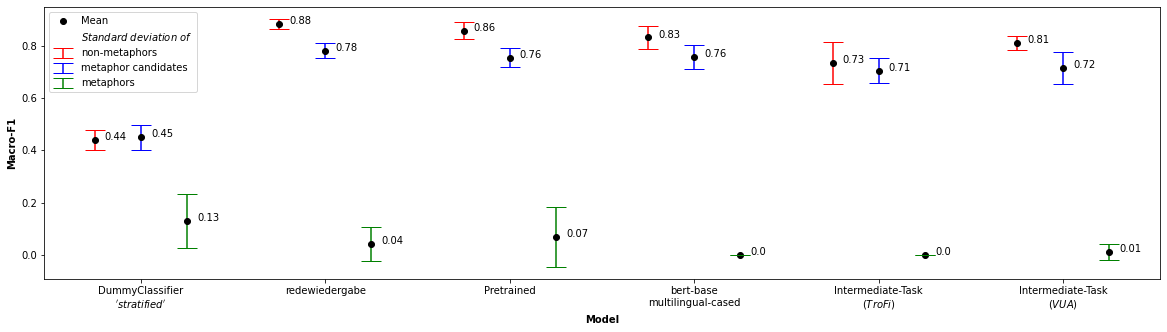

In [ ]:
# Plotting for individual classes
# Filename to save the plot to
filename = "results-unbalanced-individual"

files = unbalanced # insert foldernames of previous runs here if needed for plotting

files = [ROOT_PATH + RESULTS_PATH + "/runs/" +  x + "/results_GoldStandard.csv" for x in files]

redewiedergabe = open_csv(files[0])
fine_tuned = open_csv(files[1])
bert_base_multilingual = open_csv(files[2])
intermediate_task_trofi = open_csv(files[3])
intermediate_task_vua = open_csv(files[4])

models = {'DummyClassifier\n$\it{\'stratified\'}$': (fine_tuned[(fine_tuned.measure == 'baseline_macro_f1')].results.iloc[0], fine_tuned[(fine_tuned.measure == 'baseline_per_class_macro_f1')].results.iloc[0]), 
          'redewiedergabe': (redewiedergabe[(redewiedergabe.measure == 'evaluation_macro_f1')].results.iloc[0], redewiedergabe[(redewiedergabe.measure == 'evaluation_per_class_macro_f1')].results.iloc[0]),
          'Pretrained': (fine_tuned[(fine_tuned.measure == 'evaluation_macro_f1')].results.iloc[0],fine_tuned[(fine_tuned.measure == 'evaluation_per_class_macro_f1')].results.iloc[0]),
          'bert-base\nmultilingual-cased': (bert_base_multilingual[(bert_base_multilingual.measure == 'evaluation_macro_f1')].results.iloc[0],bert_base_multilingual[(bert_base_multilingual.measure == 'evaluation_per_class_macro_f1')].results.iloc[0]),
          'Intermediate-Task\n($\it{TroFi}$)': (intermediate_task_trofi[(intermediate_task_trofi.measure == 'evaluation_macro_f1')].results.iloc[0],intermediate_task_trofi[(intermediate_task_trofi.measure == 'evaluation_per_class_macro_f1')].results.iloc[0]),
          'Intermediate-Task\n($\it{VUA}$)': (intermediate_task_vua[(intermediate_task_vua.measure == 'evaluation_macro_f1')].results.iloc[0],intermediate_task_vua[(intermediate_task_vua.measure == 'evaluation_per_class_macro_f1')].results.iloc[0])
          } 


plt.figure(figsize=(20,5))
plt.xlabel("Model", fontweight='bold')
plt.ylabel("Macro-F1", fontweight='bold')
mean_macro = []
std_macro = []
mean_per_class_macro = []
std_per_class_macro = []
model_names = []

stride = 4

for name, data in models.items():
  macro_f1 = data[0]
  mean_macro.append(np.mean(macro_f1))
  std_macro.append(np.std(macro_f1))
  per_class_macro_f1 = data[1]
  per_class_macro_f1_mean = np.mean(per_class_macro_f1, axis=0).tolist()
  mean_per_class_macro.extend(per_class_macro_f1_mean)
  mean_per_class_macro.append(np.nan)
  std_per_class_macro.extend(np.std(per_class_macro_f1, axis=0).tolist())
  std_per_class_macro.append(np.nan)
  model_names.append(name)

x_ticks = np.arange(len(mean_per_class_macro))
classes = ['non-metaphors', 'metaphor candidates', 'metaphors']
colors = ['red', 'blue', 'green']

latex = "Oversampled "

for mean, std in zip(mean_macro, std_macro):
  latex += "& {:.2f}".format(round(mean, 2)) + " ({:.2f}) ".format(round(std, 2)) 

latex += "\\\\ dataset"

for i in range(0,len(mean_per_class_macro),stride):
  latex+= " & \\small [{:.1f}, {:.1f}, {:.1f}]".format(round(mean_per_class_macro[i], 1),round(mean_per_class_macro[i+1], 1),round(mean_per_class_macro[i+2], 1))

print(latex)

for i in range(3):
  x = [x_ticks[j] for j in range(i, len(x_ticks), stride)]
  m = [mean_per_class_macro[j] for j in range(i, len(x_ticks), stride)]
  s = [std_per_class_macro[j] for j in range(i, len(x_ticks), stride)]
  plt.errorbar(x, m, yerr=s, capsize=10, ls='none', label=classes[i], c = colors[i])


plt.scatter(x_ticks, mean_per_class_macro, c='black', zorder=2, label='Mean')

for i, v in enumerate(mean_per_class_macro):
  plt.annotate(round(v, 2), (i, v),xytext=(10, 0), textcoords='offset points')

# custom legend
plt.plot([], [], ' ', label="$\it{Standard\ deviation\ of}$")
#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = [1,0,2,3,4]
#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper left') 

model_ticks = [x*stride +1 for x in range(len(model_names))]
plt.xticks(model_ticks)
plt.axes().set_xticklabels(model_names)
filepath = ROOT_PATH + RESULTS_PATH + '/plots/' + filename + '.pdf'
print(filepath)
plt.title("")
plt.savefig(filepath, bbox_inches='tight')
plt.show()

## Multiple Annotators

/content/drive/MyDrive/DLDH/results/runs/2022-03-11-18:55:24 | redewiedergabe | EPOCHS 3 | FOLDS 10/results_T.csv
/content/drive/MyDrive/DLDH/results/runs/2022-03-11-18:55:24 | redewiedergabe | EPOCHS 3 | FOLDS 10/results_A.csv
/content/drive/MyDrive/DLDH/results/runs/2022-03-11-18:55:24 | redewiedergabe | EPOCHS 3 | FOLDS 10/results_P.csv
/content/drive/MyDrive/DLDH/results/runs/2022-03-11-18:55:24 | redewiedergabe | EPOCHS 3 | FOLDS 10/results_B.csv
/content/drive/MyDrive/DLDH/results/runs/2022-03-11-18:55:24 | redewiedergabe | EPOCHS 3 | FOLDS 10/results_K.csv
/content/drive/MyDrive/DLDH/results/runs/2022-03-11-18:55:24 | redewiedergabe | EPOCHS 3 | FOLDS 10/results_GoldStandard.csv
['T', 'A', 'P', 'B', 'K', 'GoldStandard']
/content/drive/MyDrive/DLDH/results/plots/results_all_annotators_ternary_unbalanced.pdf


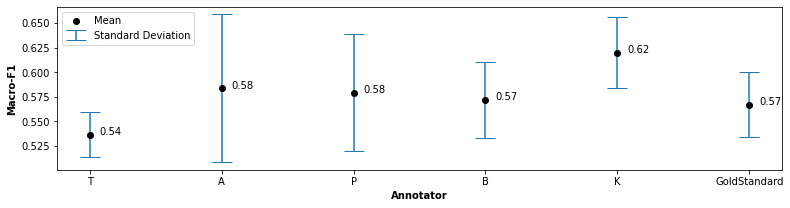

In [ ]:
annotators = ['T', 'A', 'P', 'B', 'K', 'GoldStandard']

foldername = '2022-03-11-18:55:24 | redewiedergabe | EPOCHS 3 | FOLDS 10'
filename = 'results_all_annotators_ternary_unbalanced'

annotator_names = []
dfs = pd.DataFrame()
for a in annotators:
  path = ROOT_PATH + RESULTS_PATH + '/runs/' + foldername + '/results_' + a + '.csv'
  df = open_csv_annotators(path, a)
  dfs = pd.concat([dfs, df])

plt.figure(figsize=(13,3))
plt.ylabel("Macro-F1", fontweight='bold')
plt.xlabel("Annotator", fontweight='bold')
mean = []
std = []
mean_macro = []
std_macro = []
print(annotator_names)

for a in annotator_names:
  df = dfs[dfs['annotator'] == a]
  accuracy = df[df['measure'] == 'evaluation_accuracy'].results.values[0]
  mean.append(np.mean(accuracy))
  std.append(np.std(accuracy))
  macro_f1 = df[df['measure'] == 'evaluation_macro_f1'].results.values[0]
  mean_macro.append(np.mean(macro_f1))
  std_macro.append(np.std(macro_f1))

plt.errorbar(annotator_names, mean_macro, yerr=std_macro, capsize=10, ls='none', label='Standard Deviation')
plt.scatter(annotator_names, mean_macro, c='black', zorder=2, label='Mean')
for i, v in enumerate(mean_macro):
  plt.annotate(round(v, 2), (i, v),xytext=(10, 0), textcoords='offset points')
filepath = ROOT_PATH + RESULTS_PATH + '/plots/' + filename + '.pdf'
print(filepath)
plt.title("")
plt.legend(loc='upper left')
plt.savefig(filepath, bbox_inches='tight')
plt.show()

# Oversampling

In [ ]:
# If this parameter is set true, oversampling will be performed on the dataframe
oversample_dataframe = False

# For the use of the Deepl API (is used to oversample the data set), a Deepl Authentication Key is needed
# To obtain such a key, a free trial can be started on the following page: https://www.deepl.com/docs-api/
# When 500.000 characters have been translated, a credit card is needed to start a real abonnement and to access the API
deepl_auth_key = 'DEEPL_AUTH_KEY'

# This parameter specifies the number of iterations after which the intermediate result of the dataframe should be stored repeatedly
backup_oversampled_dataframe_after_rows = 40

def set_default_staerkegrad_df(df):
  """ 
  set_default_staerkegrad accepts a dataframe as input. Checks if there is a column named "Staerkegrad"
  and if there is inserts into empty fields in that column the mostly used value from the column.

  :param df: a pandas dataframe
  :return: a pandas dataframe, where for every undefined entry in the column "Staerkgegrad" the most common value from all rows is set. If there is no such column in the input dataframe, the input dataframe is returned.  
  """
  if ('Stärkegrad (A, B, C)' not in df.columns):
    print('[set_default_staerkegrad_df]: Given dataframe does not consist of a column "Staerkegrad"!')
    return df
  else:
    most_used_staerkegrad = df['Stärkegrad (A, B, C)'].value_counts().index[0]
    df.fillna(value={'Stärkegrad (A, B, C)': most_used_staerkegrad})
    return df

def translate(text, target_language):
  """
  translate translates the input text into the target language.

  :param text: the text to be translated
  :param target_language: the deepl target language expression, examples are 'DE' or 'EN-US'
  :return: a string, the translation of :param text into the :param target_language
  """
  translator = deepl.Translator(deepl_auth_key) 
  result = translator.translate_text(text, target_lang=target_language) 
  translated_text = result.text
  return translated_text

def translate_into_english_and_back(text):
  """
  translate_into_english_and_back translates the input text into english and then into German.

  :param text: the text to be translated
  :return: a string. Returned is the result from translating :param text into englisch and after that into German.
  """
  translator = deepl.Translator(deepl_auth_key) 
  result_eng = translator.translate_text(text, target_lang='EN-US')
  result_ger = translator.translate_text(result_eng.text, target_lang='DE')
  return result_ger.text

def translate_into_target_language_and_back(text, target_language):
  """
  translate_into_target_language_and_back translates the input text into the given target_language and then into German.

  :param text: the text to be translated
  :param target_language: the language
  :return: a string. Returned is the result from translating :param text into :param target_language and then into German. 
  """
  translator = deepl.Translator(deepl_auth_key) 
  result_eng = translator.translate_text(text, target_lang=target_language)
  result_ger = translator.translate_text(result_eng.text, target_lang='DE')
  return result_ger.text

def oversample_dataframe(df):
  """
  Accepts a dataframe and returns the dataframe with oversampled data. The function was written for the known dataset of the Goldstandard. 
  In detail, every Textstelle (from metaphors only) from the input dataframe is taken, translated into four languages (english, spanish, czech and polish) and back into German.
  By this way, for each Textstelle from :param df, four new texts are generated and added to the output dataframe. 

  :param df: a pandas dataframe. 
  :return: a pandas dataframe. In the output dataframe, four columns have been added, in which the different back and forth translated German texts are. 
  """
  # Before the oversampling, the counts of unique rows in the input df and of rows which are metaphors are printed
  print('Ausprägungen und Anzahl Werte für gold_standard_df vor Oversampling:', df['Metapher?'].value_counts())
  print('Metaphern im gold_standard_df vor Oversampling', df['Metapher?'].value_counts().Metapher)

  # To backup interim results, this counter is initialized
  count = 1

  # To keep count of successfully added translated metaphor texts, the following counter is initialized
  count_successfully_added_metaphor_texts = 0

  # Split the input dataframe into two dataframes, one containing only metaphors and one with only not metaphors
  only_metaphor_df = df[(df['Metapher?'] == 'Metapher')]
  no_metaphors_df = df[(df['Metapher?'] != 'Metapher')]

  # To the dataframe containing only metaphors, add four columns where the newly generated texts can be inserted to
  only_metaphor_df['Synonym (aus Englischem)'] = ""
  only_metaphor_df['Synonym (aus Spanischem)'] = ""
  only_metaphor_df['Synonym (aus Tchechischem)'] = ""
  only_metaphor_df['Synonym (aus Polnischem)'] = ""
  
  # Loop over all rows in the dataframe containing only metaphors and translate the text back and forth and insert the German result in the correct dataframe cell
  for index, row in only_metaphor_df.iterrows():
    text = row['Textstelle']
    row['Synonym (aus Englischem)'] = translate_into_target_language_and_back(text, 'EN-US')
    row['Synonym (aus Spanischem)'] = translate_into_target_language_and_back(text, 'ES')
    row['Synonym (aus Tchechischem)'] = translate_into_target_language_and_back(text, 'CS')
    row['Synonym (aus Polnischem)'] = translate_into_target_language_and_back(text, 'PL')
    count_successfully_added_metaphor_texts += 4
    print('working, count:', count)

    # Backup interim results of the dataframe as csv files every 'backup_oversampled_dataframe_after_rows' iterations
    if (count % backup_oversampled_dataframe_after_rows == 0): 
      only_metaphor_df.to_csv('only_metaphor_df_four_languages_backup_iteration_' + str(count) + '.csv', index=False)

    # Increase counter
    count+=1

  # After the for loop, the two dataframes only metaphor and not metaphors need to get concatenated again
  oversampled_data_df = only_metaphor_df.append(no_metaphors_df)

  # After the oversampling, print the counts of unique rows in the oversampled dataframe and of rows which are metaphors again to get an overview on the results of the data augmentation 
  print('Ausprägungen und Anzahl Werte für gold_standard_df nach Oversampling:', oversampled_data_df['Metapher?'].value_counts())
  print('Metaphern im gold_standard_df nach Oversampling', oversampled_data_df['Metapher?'].value_counts().Metapher + count_successfully_added_metaphor_texts)

  return oversampled_data_df

# If the related parameter is set to true and a valid Deepl API Key is present, oversampling will be performed on the raw_df and this oversampled_data_df will be saved as .csv file
#if (oversample_dataframe and deepl_auth_key != 'DEEPL_AUTH_KEY'):
#  oversampled_data_df = oversample_dataframe(gold_standard_df)
#  oversampled_data_df.to_csv('goldstandard_dataframe_oversampled.csv', index=False)

# DAS IST DER AUFRUF ZUM OVERSAMPLEN; DER MUSS NOCH AN DER KORREKTEN STELLE EINGEBAUT WERDEN. 
